# IV.E - Sensitivity Analysis: Timestamp Manipulation

In [ ]:
# !pip install --upgrade scikit-image
# !pip install pyproj
# !pip install tqdm
# !pip install -U scipy==1.0.0

### Imports & Definitions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

import os, sys

from itertools import product
import pyproj


sys.path.append("../../datasets")
from dataLoader import DataLoader, preprocess_time


from tf.keras.models import Model, load_model
from tf.keras.layers import Input
from tf.keras.losses import mean_squared_error



batchSize = 1
pathToModel = "../IV.B_ablation_study/denseNet/gr_oh_loc_time_TA/weights.30-0.57407.hdf5"
gpuNumber = 4


## GPU selection
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[gpuNumber], 'GPU')
tf.config.experimental.set_memory_growth(gpus[gpuNumber], True)



#######################
##    Custom MSE     ##
#######################
# We will compute the MSE only for the consistent inputs
def transient_mse(y_true, y_pred):
    return tf.sum(mean_squared_error(y_true[0::2,:], y_pred[0::2,:]), axis=-1)



#######################
## Deprocess time
#######################
def deprocess_time(time):
    month, hour = time
    month = (11.0 / 2.0) * (month + 1) + 1
    hour = (23.0 / 2.0) * (hour + 1)
    return (int(round(month)), int(round(hour)))

def deprocess_loc(loc):
    _earth_radius = 6378137.0
    x,y,z = loc
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    
    lon, lat, alt = pyproj.transform(ecef, lla, x * _earth_radius, y*_earth_radius, z*_earth_radius, radians=False)
    return (lat, lon, alt)

Using TensorFlow backend.


### Methods to generate shifted times

In [5]:
def generate_shifted_hour(time, hourShift):
    month, hour = time
    timeList = [(month, (hour+(mult * hourShift))%24) for mult in [-1, 1]]
    return timeList
        
def generate_shifted_month(time, monthShift):
    month, hour = time
    timeList = [((month - 1 + (mult*monthShift))%12 + 1, hour) for mult in [-1, 1]]
    return timeList

def generate_shifted_hour_and_month_shift(time, hourShift, monthShift):
    month, hour = time
    
    if monthShift == 0:
        timeList = generate_shifted_hour(time, hourShift)
    elif hourShift == 0:
        timeList = generate_shifted_month(time, monthShift)
    else:
        timeList = [((month - 1 + (multM*monthShift))%12 + 1, (hour+(multH * hourShift))%24) 
                    for multM in [-1, 1] for multH in [-1, 1]]
    return timeList

### Load architecture and get pointers to specific layers
As we will process the features from multiple timestamps, we avoid re-processing the features for the ground-level image, location, and satellite image

In [4]:
baseModel = load_model(pathToModel, custom_objects={"transient_mse": transient_mse})
print(baseModel.summary())

groundBranchModel = Model(baseModel.get_layer("groundInput").input, 
                          baseModel.get_layer("batch_normalization_2").output)
aerialBranchModel = Model(baseModel.get_layer("aerialInput").input, 
                          baseModel.get_layer("batch_normalization_4").output)
locBranchModel = Model(baseModel.get_layer("locationInput").input, 
                       baseModel.get_layer("batch_normalization_7").output)
timeBranchModel =  Model(baseModel.get_layer("timeInput").input, 
                         baseModel.get_layer("batch_normalization_10").output)


combinedFeaturesInput = Input(shape=(512,), name='concatenate_1_proxy')
combinedFeatures = baseModel.get_layer("consist_fc1")(combinedFeaturesInput)
combinedFeatures = baseModel.get_layer("batch_normalization_11")(combinedFeatures)
combinedFeatures = baseModel.get_layer("consist_fc2")(combinedFeatures)
combinedFeatures = baseModel.get_layer("batch_normalization_12")(combinedFeatures)
combinedFeatures = baseModel.get_layer("consist_fc3")(combinedFeatures)
combineModel = Model(combinedFeaturesInput, combinedFeatures)

-------
-------
-------

## Considering Month or Hour Shifts separately

In [17]:
dl = DataLoader("test", 
                includeLocation = True, 
                includeSatellite = True, 
                outputTransientAttributes = True)

hourShiftList = [1,2,3,4,5,6,7,8,9,10,11,12]
monthShiftList = [1,2,3,4,5,6]

nDetectedHour = np.zeros(len(hourShiftList))
nDetectedMonth = np.zeros(len(monthShiftList))

nImgs = 0.0
for batch, _ in dl.loadTestDataInBatches(batchSize):
    grImg, aeImg, locInfo, timeInfo = [batch[i][0:1] for i in range(len(batch))]

    timeInfo = deprocess_time(timeInfo[0])

    grFeatures = groundBranchModel.predict_on_batch(grImg)
    aeFeatures = aerialBranchModel.predict_on_batch(aeImg)
    locFeatures = locBranchModel.predict_on_batch(locInfo)

    timeList, predList = [], []
    for month, hour in product(range(1,13), range(24)):
        timeFeatures = timeBranchModel.predict_on_batch(preprocess_time((month, hour)).reshape(1,-1))
        
        concatFV = np.hstack((grFeatures, aeFeatures, locFeatures, timeFeatures))
        pred = combineModel.predict_on_batch(concatFV)[0]
        
        y_pred = np.argmax(pred)
        
        timeList += [(month, hour)]
        predList += [y_pred]
    
    detectedTime = [timeList[idx] for idx in range(len(timeList)) if predList[idx] == 1]
    
    for (idx, shift) in enumerate(hourShiftList):
        tamperedList = generate_shifted_hour(timeInfo, shift)
        nDetectedHour[idx] += sum([1 for tamperedTime in tamperedList if tamperedTime in detectedTime])
        
    for (idx, shift) in enumerate(monthShiftList):
        tamperedList = generate_shifted_month(timeInfo, shift)
        nDetectedMonth[idx] += sum([1 for tamperedTime in tamperedList if tamperedTime in detectedTime])
    
    nImgs += 1
    
    if nImgs%50 == 0:
        print("nImgs = ", nImgs)
        print("Hour % of rejected: ", nDetectedHour/(2*nImgs))
        print("Month % of rejected: ", nDetectedMonth/(2*nImgs), "\n\n")

nImgs =  50.0
Hour % of rejected:  [0.1  0.24 0.39 0.55 0.67 0.74 0.82 0.81 0.84 0.88 0.91 0.9 ]
Month % of rejected:  [0.19 0.41 0.72 0.82 0.85 0.88] 


nImgs =  100.0
Hour % of rejected:  [0.085 0.21  0.355 0.48  0.585 0.68  0.76  0.8   0.86  0.905 0.905 0.9  ]
Month % of rejected:  [0.16  0.42  0.74  0.875 0.895 0.92 ] 


nImgs =  150.0
Hour % of rejected:  [0.07666667 0.21333333 0.37333333 0.49333333 0.6        0.67333333
 0.75666667 0.79666667 0.86666667 0.89666667 0.90333333 0.89333333]
Month % of rejected:  [0.16666667 0.43       0.73       0.85666667 0.89       0.90666667] 


nImgs =  200.0
Hour % of rejected:  [0.0675 0.2075 0.36   0.49   0.6075 0.6775 0.7575 0.8025 0.8525 0.8875
 0.89   0.88  ]
Month % of rejected:  [0.1475 0.445  0.7275 0.865  0.905  0.92  ] 


nImgs =  250.0
Hour % of rejected:  [0.064 0.202 0.356 0.502 0.622 0.704 0.774 0.814 0.856 0.884 0.888 0.876]
Month % of rejected:  [0.132 0.43  0.708 0.848 0.89  0.912] 


nImgs =  300.0
Hour % of rejected:  [0.07   

nImgs =  1750.0
Hour % of rejected:  [0.07771429 0.17657143 0.354      0.51942857 0.63457143 0.71828571
 0.77714286 0.82028571 0.84428571 0.86514286 0.874      0.87028571]
Month % of rejected:  [0.14571429 0.45457143 0.71942857 0.84371429 0.88828571 0.90057143] 


nImgs =  1800.0
Hour % of rejected:  [0.07638889 0.17611111 0.35444444 0.51972222 0.63527778 0.71861111
 0.77694444 0.82       0.84416667 0.86611111 0.87388889 0.87055556]
Month % of rejected:  [0.14444444 0.45444444 0.71972222 0.84222222 0.88611111 0.89777778] 


nImgs =  1850.0
Hour % of rejected:  [0.0772973  0.1772973  0.35675676 0.52081081 0.63540541 0.71783784
 0.77621622 0.81972973 0.84378378 0.86621622 0.87486486 0.87189189]
Month % of rejected:  [0.14513514 0.45324324 0.71864865 0.84243243 0.88675676 0.89837838] 


nImgs =  1900.0
Hour % of rejected:  [0.07605263 0.17605263 0.35552632 0.52157895 0.63657895 0.71868421
 0.77631579 0.82026316 0.845      0.86736842 0.87552632 0.87315789]
Month % of rejected:  [0.14342105

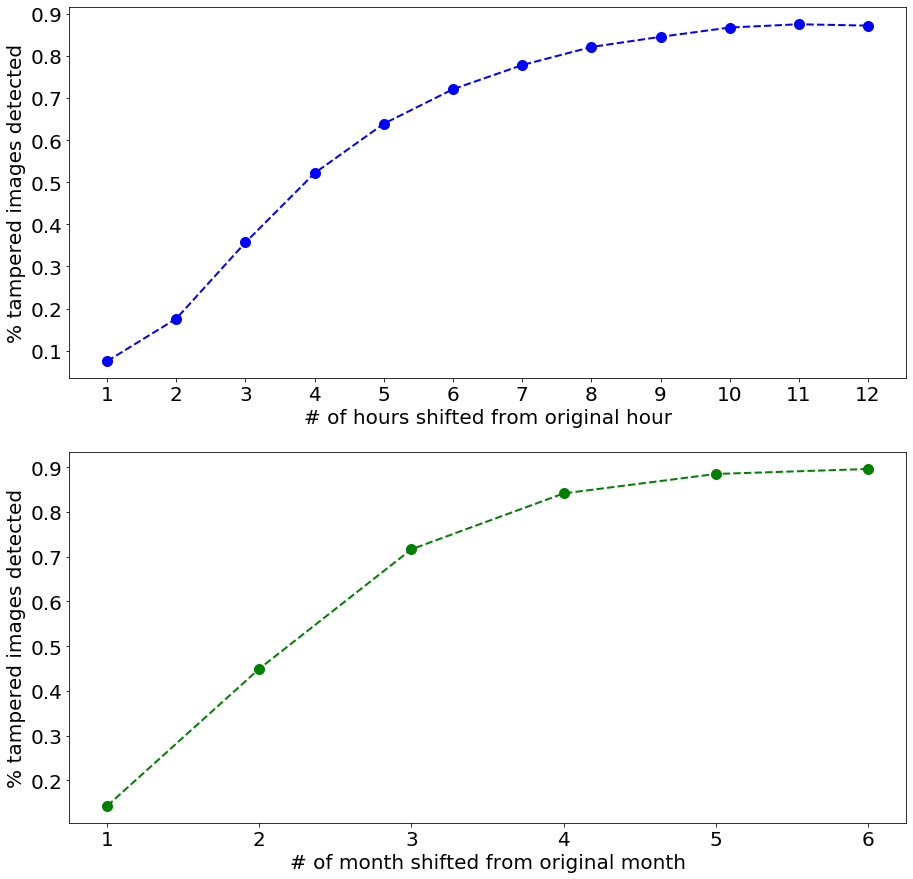

In [19]:
plt.rcParams.update({'font.size': 20})


fig=plt.figure(figsize=(15, 15))
columns = 1
rows = 2

fig.add_subplot(rows, columns, 1)
plt.plot(hourShiftList, nDetectedHour/(2*nImgs), color='blue', marker='o', linestyle='dashed', 
         linewidth=2, markersize=10)
plt.xticks(range(1,len(hourShiftList)+1), hourShiftList)
plt.ylabel("% tampered images detected")
plt.xlabel("# of hours shifted from original hour")

fig.add_subplot(rows, columns, 2)
plt.plot(monthShiftList, nDetectedMonth/(2*nImgs), color='green', marker='o', linestyle='dashed', 
         linewidth=2, markersize=10)
plt.xticks(range(1,len(monthShiftList)+1), monthShiftList)
plt.ylabel("% tampered images detected")
plt.xlabel("# of month shifted from original month")

plt.show()

## Considering Month and Hour Shifts Simultaneously

In [11]:
dl = DataLoader("test")

hourShiftList = [0,1,2,3,4,5,6,7,8,9,10,11,12]
monthShiftList = [0,1,2,3,4,5,6]

nDetected = np.zeros((len(monthShiftList), len(hourShiftList)))

nImgs = 0.0
for batch, _ in dl.loadTestDataInBatches(batchSize, allTestSet=True):
    grImg, aeImg, locInfo, timeInfo = [batch[i][0:1] for i in range(len(batch))]

    timeInfo = deprocess_time(timeInfo[0])

    grFeatures = groundBranchModel.predict_on_batch(grImg)
    aeFeatures = aerialBranchModel.predict_on_batch(aeImg)
    locFeatures = locBranchModel.predict_on_batch(locInfo)

    timeList, predList = [], []
    for month, hour in product(range(1,13), range(24)):
        timeFeatures = timeBranchModel.predict_on_batch(preprocess_time((month, hour)).reshape(1,-1))
        
        concatFV = np.hstack((grFeatures, aeFeatures, locFeatures, timeFeatures))
        pred = combineModel.predict_on_batch(concatFV)[0]
        
        y_pred = np.argmax(pred)
        
        timeList += [(month, hour)]
        predList += [y_pred]
    
    detectedTime = [timeList[idx] for idx in range(len(timeList)) if predList[idx] == 1]
    
    for (mIdx, mShift) in enumerate(monthShiftList):
        for (hIdx, hShift) in enumerate(hourShiftList):
            if mShift == 0 and hShift == 0:
                continue
            tamperedList = generate_shifted_hour_and_month_shift(timeInfo, hShift, mShift)
            nDetected[mIdx, hIdx] += sum([1 for tamperedTime in tamperedList if tamperedTime in detectedTime])
    
    nImgs += 1
    
    if nImgs%50 == 0:
        print("nImgs = ", nImgs)

('nImgs = ', 50.0)
('nImgs = ', 100.0)
('nImgs = ', 150.0)
('nImgs = ', 200.0)
('nImgs = ', 250.0)
('nImgs = ', 300.0)
('nImgs = ', 350.0)
('nImgs = ', 400.0)
('nImgs = ', 450.0)
('nImgs = ', 500.0)
('nImgs = ', 550.0)
('nImgs = ', 600.0)
('nImgs = ', 650.0)
('nImgs = ', 700.0)
('nImgs = ', 750.0)
('nImgs = ', 800.0)
('nImgs = ', 850.0)
('nImgs = ', 900.0)
('nImgs = ', 950.0)
('nImgs = ', 1000.0)
('nImgs = ', 1050.0)
('nImgs = ', 1100.0)
('nImgs = ', 1150.0)
('nImgs = ', 1200.0)
('nImgs = ', 1250.0)
('nImgs = ', 1300.0)
('nImgs = ', 1350.0)
('nImgs = ', 1400.0)
('nImgs = ', 1450.0)
('nImgs = ', 1500.0)
('nImgs = ', 1550.0)
('nImgs = ', 1600.0)
('nImgs = ', 1650.0)
('nImgs = ', 1700.0)
('nImgs = ', 1750.0)
('nImgs = ', 1800.0)
('nImgs = ', 1850.0)
('nImgs = ', 1900.0)
('nImgs = ', 1950.0)
('nImgs = ', 2000.0)
('nImgs = ', 2050.0)
('nImgs = ', 2100.0)
('nImgs = ', 2150.0)
('nImgs = ', 2200.0)
('nImgs = ', 2250.0)
('nImgs = ', 2300.0)
('nImgs = ', 2350.0)
('nImgs = ', 2400.0)
('nImgs = ',

KeyboardInterrupt: 

In [12]:
tNDetected = np.copy(nDetected)
tNDetected[:,0] /= (2*nImgs)
tNDetected[0,:] /= (2*nImgs)
tNDetected[1:,1:] /= (4*nImgs)
tNDetected

array([[0.        , 0.07322028, 0.16384031, 0.34702349, 0.55352411,
        0.70199611, 0.79994701, 0.86309839, 0.90558205, 0.93040099,
        0.93941   , 0.94488606, 0.94682918],
       [0.14785374, 0.18097509, 0.29650238, 0.47968557, 0.65491963,
        0.77649709, 0.84971736, 0.89917859, 0.92995937, 0.94665253,
        0.95495495, 0.95932697, 0.96051934],
       [0.47747748, 0.51187953, 0.61066949, 0.72862568, 0.82631161,
        0.88623918, 0.92360007, 0.94599011, 0.96171171, 0.97054407,
        0.97535771, 0.97875817, 0.97933227],
       [0.75189896, 0.77137432, 0.82039392, 0.87299064, 0.91233881,
        0.93826179, 0.95460166, 0.96696697, 0.97575517, 0.98229111,
        0.98622152, 0.98798799, 0.98922452],
       [0.86000707, 0.87073839, 0.8930401 , 0.91794736, 0.9366278 ,
        0.95345345, 0.96528882, 0.97425367, 0.9818495 , 0.98688394,
        0.98931284, 0.99138845, 0.99249249],
       [0.89727963, 0.90284402, 0.91560678, 0.93243243, 0.94674086,
        0.95897368, 0.96930

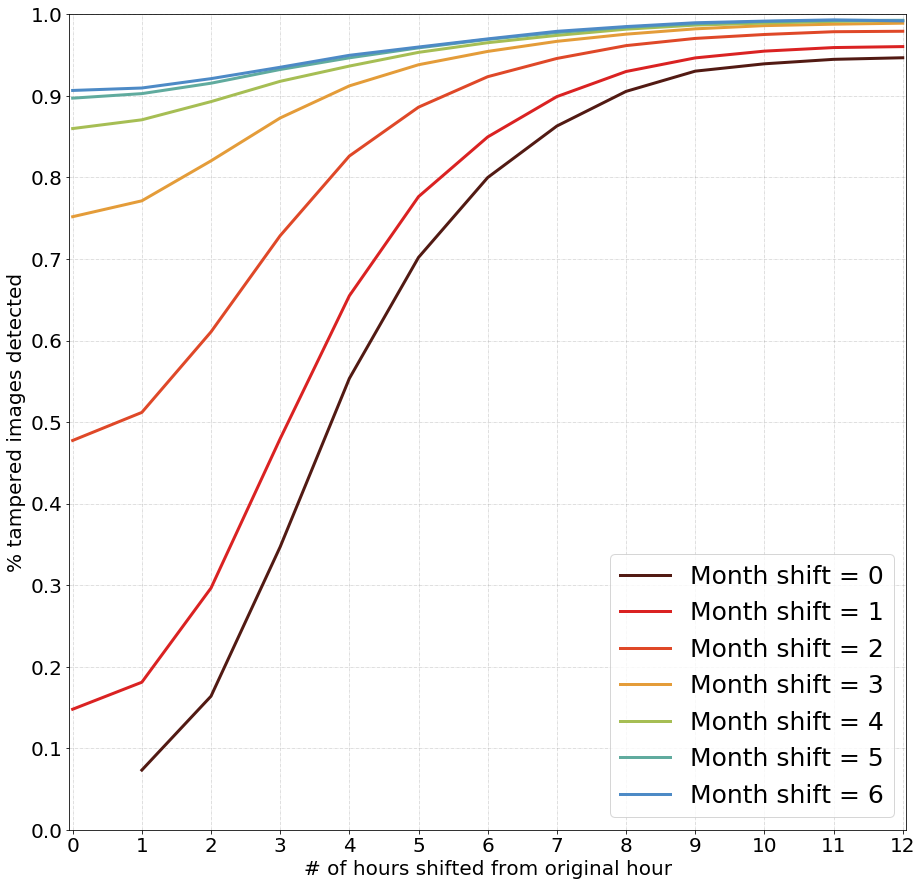

In [13]:
plt.rcParams.update({'font.size': 20})

fig=plt.figure(figsize=(15, 15))
columns = 1
rows = 1

fig.add_subplot(rows, columns, 1)
plt.ylabel("% tampered images detected")
plt.xlabel("# of hours shifted from original hour")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.grid(True, which='major', color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)


colorList = ["#4D8AC6", "#60AB9E", "#A6BE54", "#E49C39", "#DF4828", "#DA2222", "#521A13"][::-1]

for (mIdx, mShift) in enumerate(monthShiftList):
    if mIdx == 0:
        plt.plot(hourShiftList[1:], tNDetected[mIdx, 1:], color=colorList[mIdx], linestyle='-', 
                     lw=3, label = "Month shift = " + str(mShift))
    else:
        plt.plot(hourShiftList, tNDetected[mIdx], color=colorList[mIdx], linestyle='-', 
                     lw=3, label = "Month shift = " + str(mShift))

plt.ylim([0.0, 1.0])
plt.xlim([-0.05, 12.05])
plt.xticks(range(0,len(hourShiftList)), hourShiftList)
plt.legend(loc="lower right", prop={'size': 25})
plt.show()

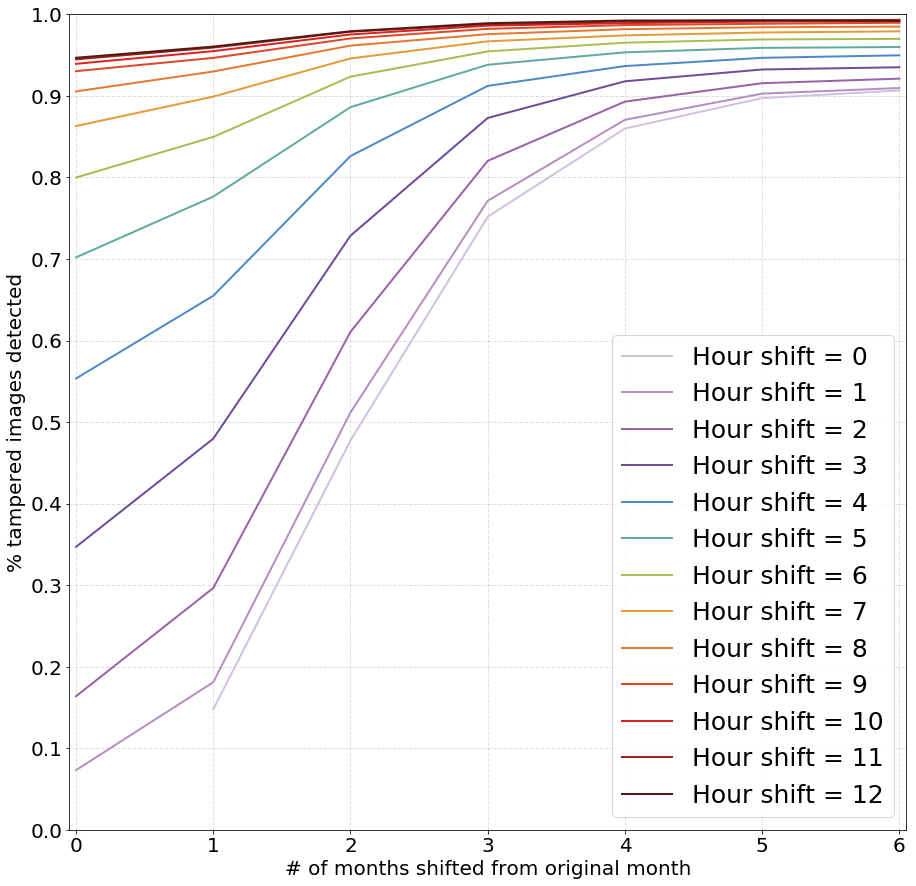

In [14]:
fig=plt.figure(figsize=(15, 15))
columns = 1
rows = 1

fig.add_subplot(rows, columns, 1)
plt.ylabel("% tampered images detected")
plt.xlabel("# of months shifted from original month")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.grid(True, which='major', color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)


colorList = ["#D1C1E1", "#B58FC2", "#9B62A7", "#6F4C9B", "#4D8AC6", "#60AB9E", "#A6BE54",  
             "#E49C39", "#E67932", "#DF4828", "#DA2222", "#95211B", "#521A13"]


for (hIdx, hShift) in enumerate(hourShiftList):
    if hIdx == 0:
        plt.plot(monthShiftList[1:], tNDetected[1:,hIdx], color=colorList[hIdx], 
             linestyle='-', lw=2, label = "Hour shift = " + str(hShift))
    else:
        plt.plot(monthShiftList, tNDetected[:,hIdx], color=colorList[hIdx], 
             linestyle='-', lw=2, label = "Hour shift = " + str(hShift))

plt.ylim([0.0, 1.0])
plt.xlim([-0.05, 6.05])
plt.xticks(range(0,len(monthShiftList)), monthShiftList)
plt.legend(loc="lower right", prop={'size': 25})
plt.show()